In [ ]:
# Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from fetchData import fetchdata 

In [4]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [107]:
pheme_w2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv').Event

ext_w2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event

rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
rhi_y = pd.read_csv('./data/_RHI_target.csv')

pheme_bert = fetchdata('pheme','bert')
ext_bert = fetchdata('ext','bert')
rhi_bert = fetchdata('rhi','bert')

In [6]:
pheme_sparse.verified = pheme_sparse.verified.replace({True: 1, False: 0}) 
ext_sparse.verified = ext_sparse.verified.replace({True: 1, False: 0}) 
pheme_sparse.has_question = pheme_sparse.has_question.replace({True: 1, False: 0}) 
ext_sparse.has_question = ext_sparse.has_question.replace({True: 1, False: 0}) 
pheme_sparse.has_exclaim = pheme_sparse.has_exclaim.replace({True: 1, False: 0}) 
ext_sparse.has_exclaim = ext_sparse.has_exclaim.replace({True: 1, False: 0}) 
pheme_sparse.has_period = pheme_sparse.has_period.replace({True: 1, False: 0}) 
ext_sparse.has_period = ext_sparse.has_period.replace({True: 1, False: 0}) 

In [ ]:
# Sparse-MLP

In [ ]:
PATH = './MLP_W2V_to_Sigmoid_ord.pt'
# bn_state_dict = torch.load('./BERT_raw_to_fine_tune_ord.pt')
# bert_classifier.load_state_dict(bn_state_dict)
model.load_state_dict(torch.load(PATH))

In [46]:
train_inputs = torch.tensor(pheme_sparse.values).float()
val_inputs = torch.tensor(ext_sparse.values).float()

# Convert other data types to torch.Tensor
train_labels = torch.tensor(pheme_y.values).float()
val_labels = torch.tensor(ext_y.values).float()

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
# train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [55]:
class model1(nn.Module):
    def __init__(self):
        super(model1, self).__init__()
        self.fc1 = nn.Linear(in_features=27, out_features=8, bias=True)
        self.fc2 = nn.Linear(in_features=8, out_features=4, bias=True)
        self.output = nn.Linear(in_features=4, out_features=1, bias=True)
        self.drop2 = nn.Dropout(0.2)
        # self.softmax = nn.Linear(dim=1)

    def forward(self, x):
        x = self.drop2(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x


def train(train_loader, val_dataloader=None, epochs=100, verbose=True, evaluation=False):
    prev_loss = 10
    PATH = "./state_dict_model_ai_task1.pt"

    print("Start training...\n")
    val_loss_list = []
    val_acc_list = []
    train_loss = []         # training 과정에서 각 epoch마다의 평균 loss를 저장
    train_accuracy = []     # training 과정에서 각 epoch마다의 평균 acc를 저장
    train_correct = []
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")


    num_step = len(train_loader)

    for epoch in range(epochs):
        epoch_count = 0
        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.train()
        # print('Epoch {}/{}'.format(epoch, epochs - 1))
        # print('-' * 10)
        epoch_corrects = 0  # 한 epoch마다 각 batch의 데이터를 저장
        epoch_loss = 0
        epoch_accuracy = []
        temp=[]

        for i, data in enumerate(train_loader):
            batch_count = 0

            train, label = data
            train, label = train.float(), label.float()

            output = model.forward(train)

            # _, preds = torch.max(output, 1)
            y2 = torch.zeros(len(output))
            y2[output.flatten()>=0.5] = 1
            # print(preds)
            # print(label)
            acc = (y2.int() == label).cpu().numpy().mean() * 100
            batch_correct = (y2.int() == label).cpu().numpy().sum()
            temp.append(batch_correct)

            # loss = criterion(output.float(), label.unsqueeze(1).float())
            loss = criterion(output.float(), label.float())
            batch_loss += loss.item()
            # total_loss += loss.item()

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            # print(loss.item())
            # print(train.size(0))
            epoch_loss += loss.item()*train.size(0)
            epoch_accuracy.append(acc)
            # print(torch.sum(preds == label))
            # epoch_corrects.append(torch.sum(preds == label))

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            batch_count += len(label)
        epoch_corrects += batch_correct
        epoch_loss = epoch_loss/len(train_loader.sampler)
        epoch_accruacy = epoch_corrects / batch_count
        # avg_train_loss = total_loss / len(train_dataloader)
        # print(temp)
        # print(np.sum(temp))

        # train_loss.append(epoch_corrects)
        train_accuracy.append(epoch_accruacy)
        train_correct.append(epoch_corrects)
        train_loss.append(epoch_loss)

        if epoch % 10 == 0 and verbose == True:
            print("Epoch: {}, Loss: {:.5f}".format(epoch + 1, loss.item()))
            print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, np.mean(epoch_accuracy)))

        if epoch % 5 == 0 and loss < prev_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print("Saving the best model")
            torch.save(model.state_dict(), PATH)
            prev_loss = loss.item()
        

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.

            val_correct, val_acc, val_loss = evaluate(val_dataloader)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

            # Print performance over the entire training data
            # print(val_loss_list)
            # print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9}")
            if epoch % 10 == 0 and verbose == True:
                print(
                    f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f} | {val_loss:^10.6f} | {val_acc:^9.2f}")
                print("-"*70)
            if epoch % 5 == 0 and loss < prev_loss:
                print("Saving the best model")
                torch.save(model.state_dict(), PATH)
                prev_loss = loss.item()
        else:
            if epoch % 10 == 0 and verbose == True:
                print(
                    f"{epoch + 1:^7} | {'-':^7} | {epoch_loss:^12.6f}")
                print("-"*70)
            if epoch % 5 == 0 and loss < prev_loss:
                print("Saving the best model")
                torch.save(model.state_dict(), PATH)
                prev_loss = loss.item()
            
    # torch.save(model.state_dict(),PATH)

    fig, ax = plt.subplots(3, 1, figsize=(12,8))
    ax[0].plot(train_loss)
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_accuracy)
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_acc_list)
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

    print("Accuracy: {}, Loss: {:.5f}".format(train_accuracy[-1], loss.item()))
    # return train_loss, train_accuracy, loss


def evaluate(val_dataloader, verbose=True):
    correct = 0
    total = 0
    outputs_list = []

    val_loss = []
    val_corrects = 0
    val_acc = []
    valid_loss = 0.0

    batch_count = 0

    model.eval()
    with torch.no_grad():
        for j, val in enumerate(val_dataloader):
            inputs, label = val
            inputs, label = inputs.float(), label.float()
            output = model(inputs)
            # _, preds = torch.max(output, 1)
            
            
            loss = criterion(output, label.unsqueeze(1))

            y2 = torch.zeros(len(output))
            y2[output.flatten()>=0.5] = 1

            acc = (y2.int() == label.int()).cpu().numpy().mean() * 100
            correct = (y2.int() == label.int()).cpu().numpy().sum()
            # print(correct)

            # print((preds == label).cpu().numpy().sum())

            val_loss.append(loss.item())
            val_corrects += correct
            val_acc.append(acc)
            batch_count += len(inputs)
            valid_loss += loss.item()*inputs.size(0)

            # print(j,len(inputs),correct)


    total_correct = np.sum(val_corrects)
    # total_loss = np.mean(val_loss)
    # print("val_corrects:", val_corrects)
    # print("batch count:", batch_count)
    # print("batch valid_loss:", valid_loss)
    
    total_acc = val_corrects/batch_count
    # print("total_acc:", total_acc)
    # print("Validation) Acc: {:.4f} ".format(total_acc))
    valid_loss = valid_loss/len(val_dataloader.sampler)
    # print("batch valid_loss 2:", valid_loss)


    return val_corrects, total_acc, valid_loss


In [355]:
model = model1()
model

model1(
  (fc1): Linear(in_features=27, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
Epoch: 1, Loss: 0.57264
Train) Loss: 0.6833 Acc: 49.5810
Saving the best model
   1    |    -    |   0.683254   |  0.757441  |   0.24   
----------------------------------------------------------------------
Epoch: 11, Loss: 0.73136
Train) Loss: 0.6880 Acc: 48.7019
  11    |    -    |   0.688004   |  0.728786  |   0.24   
----------------------------------------------------------------------
Epoch: 21, Loss: 0.63560
Train) Loss: 0.6869 Acc: 49.6326
  21    |    -    |   0.686880   |  0.729639  |   0.24   
----------------------------------------------------------------------
Epoch: 31, Loss: 0.67218
Train) Loss: 0.6838 Acc: 50.2747
  31    |    -    |   0.683782   |  0.749396  |   0.24   
----------------------------------------------------------------------
Epoch: 41, Loss: 0.71308
Train) Loss: 0.6868 Acc: 49.6944
  41    |    -    |   0.686822   |  0.726374  |   0.24   
--------------------------------------

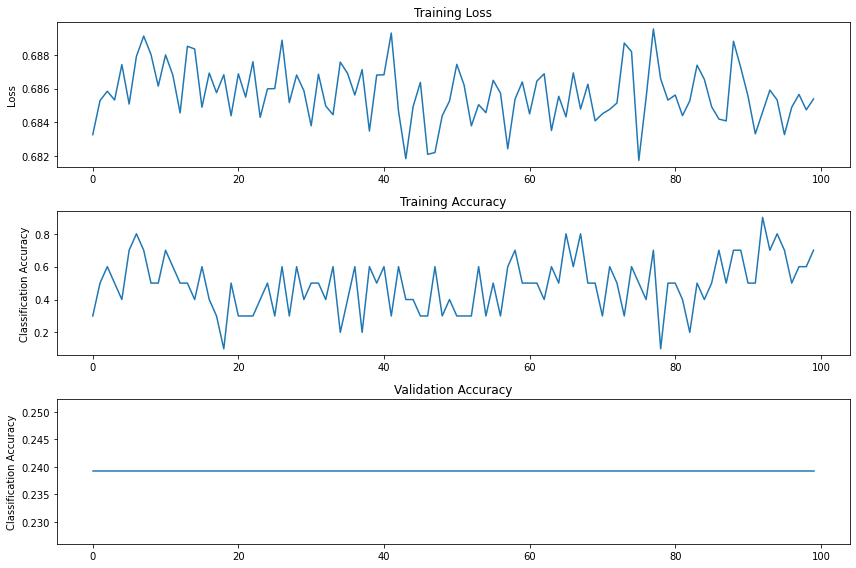

Accuracy: 0.7, Loss: 0.76088


In [357]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train(train_dataloader, val_dataloader=val_dataloader, epochs=100, evaluation=True)

In [ ]:
### Molecular Activity Data

In [33]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_train = pd.DataFrame(data['data'])
y_train = pd.DataFrame(data['target'])

# train_test_split(pd.concat([X_train]), random_state=42)


In [34]:
X_train.shape

(569, 30)

In [38]:
from torch.utils.data.sampler import WeightedRandomSampler

train_inputs = torch.tensor(X_train.values)
# val_inputs = torch.tensor(X_test.values)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train.values)
# val_labels = torch.tensor(y_test.values)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
# counts = np.bincount(y_train.values)
# print(count)
# labels_weights = 1. / counts
# weights = labels_weights[pheme_y.values]
# train_sampler = WeightedRandomSampler(weights, len(weights))


# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# # Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [39]:
model = model1()
model

model1(
  (fc1): Linear(in_features=30, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc 
Epoch: 1, Loss: 0.66275
Train) Loss: 18.7595 Acc: 41.8715
Saving the best model
   1    |    -    |  18.759461  
----------------------------------------------------------------------
Epoch: 11, Loss: 0.67435
Train) Loss: 0.6604 Acc: 62.7083
  11    |    -    |   0.660370  
----------------------------------------------------------------------
Saving the best model
Epoch: 21, Loss: 0.65412
Train) Loss: 0.6610 Acc: 42.4514
  21    |    -    |   0.660954  
----------------------------------------------------------------------
Epoch: 31, Loss: 0.63316
Train) Loss: 0.6605 Acc: 62.8056
  31    |    -    |   0.660469  
----------------------------------------------------------------------
Epoch: 41, Loss: 0.69519
Train) Loss: 0.6605 Acc: 62.6597
  41    |    -    |   0.660493  
----------------------------------------------------------------------
Epoch: 51, Loss: 0.65396
Train) Loss: 0.6606 Acc: 62.7569
  51    |  

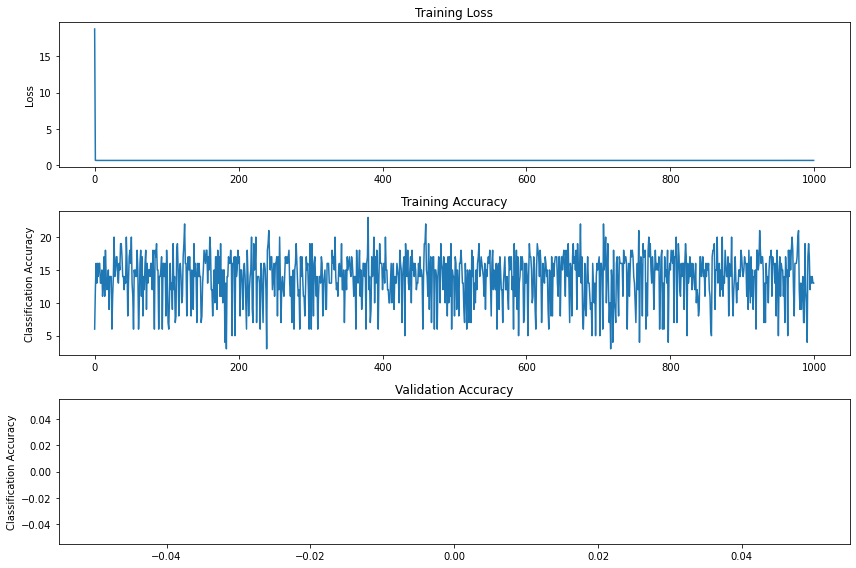

Accuracy: 13.0, Loss: 0.71637


In [40]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

# train_loss, train_accuracy, loss = 
train(train_dataloader, val_dataloader=None, epochs=1000, evaluation=True)

In [ ]:
torch.save(model.state_dict(), './MLP_Sparse_CLF_ord.pt')

In [ ]:
# Sparse-MLP - again

In [94]:
tensor_x1 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_sparse.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

task1_train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
task1_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

In [95]:
print(tensor_x1.shape)
print(tensor_y1.shape)
print(train_size)
print(test_size)

torch.Size([5802, 1, 27])
torch.Size([5802, 1])
5802
485


In [96]:
class FC_net(nn.Module):
    def __init__(self):
        super(FC_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(27, 12, bias=True) # 420
        self.fc2 = nn.Linear(12, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

class Conv1d_net_mod(nn.Module):
    def __init__(self):
        super(Conv1d_net_mod, self).__init__() # 1*20
        self.conv1 = nn.Conv1d(1, 5, 2, padding=1) # 6@1*20
        self.pool = nn.MaxPool1d(2) # 6@10
        self.fc1 = nn.Linear(50, 24)
        self.fc2 = nn.Linear(24, 8)
        self.fc3 = nn.Linear(8, 3)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.conv1_bn = nn.BatchNorm1d(5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1_bn(self.conv1(x))))
        x = x.view(-1, 50) 
        x = self.drop_4(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
sparseModel = FC_net()

In [97]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(sparseModel.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(sparseModel.parameters(), lr=0.1)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

In [98]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task1_model.pt"
best_acc = 10.0
num_epochs = 30

val_corrects_list = []
val_loss_list = []

In [99]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # print('-' * 10)
    running_corrects = 0.0
    running_loss = 0.0
    sparseModel.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = sparseModel(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # step function
        scheduler.step() 

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    if (epoch%3==0):
        print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch, num_epochs - 1,epoch_acc, epoch_loss))

    sparseModel.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        val_preds_list = []
        val_label_list = []
        for j, val in enumerate(task1_test_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = sparseModel(val_x)
            _, val_preds = torch.max(val_outputs, 1)

            val_preds_list.append(val_preds.data)
            val_label_list.append(val_label.data)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label.data).double()
        if (epoch%3==0):
            val_preds_list = torch.cat(val_preds_list, 0)
            val_label_list = torch.cat(val_label_list, 0)
            print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size,val_loss/test_size,f1_score(val_label_list,val_preds_list,average='macro')))
        val_corrects_list.append(val_corrects/test_size)
        val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(sparseModel.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/29	Train) Acc: 0.5031, Loss: 8.0199
		Validation) Acc: 0.2392 Loss:0.6880 F1 score: 0.193012
Saving the best model w/ loss 8.0199
Saving the best model w/ loss 0.7192
Epoch 3/29	Train) Acc: 0.5012, Loss: 0.7266
		Validation) Acc: 0.2392 Loss:0.7091 F1 score: 0.193012


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-99-c670ab06217a>", line 7, in <module>
    for i, data in enumerate(task1_train_dataloader, 0):
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 517, in __next__
    data = self._next_data()
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1182, in _next_data
    idx, data = self._get_data()
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1148, in _get_data
    success, data = self._try_get_data()
  File "/Users/june/miniconda3/envs/rosetta/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 986, in _try_get_data
    data = self._data_queue.get(timeout=t

TypeError: object of type 'NoneType' has no len()

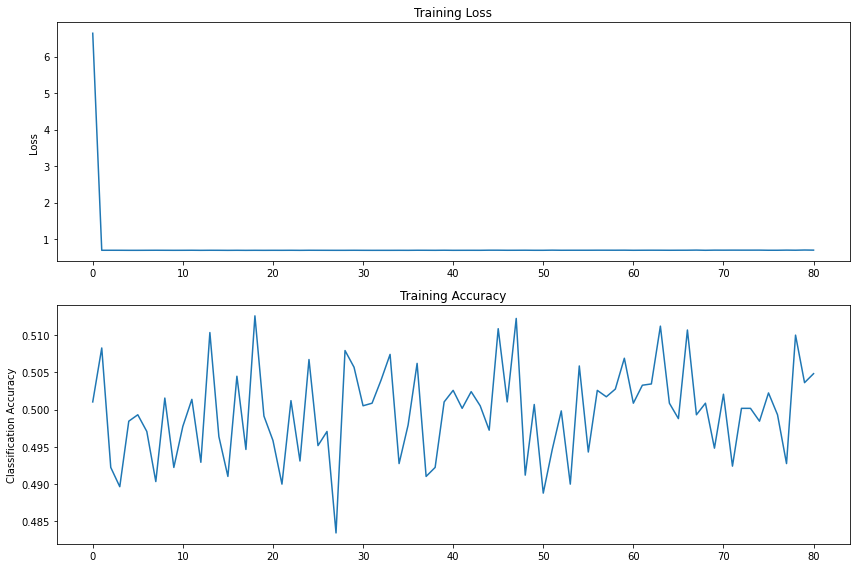

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# W2V-MLP

In [100]:
tensor_x1 = torch.Tensor(pheme_w2v.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_w2v.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

task1_train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
task1_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

In [101]:
print(tensor_x1.shape)
print(tensor_y1.shape)
print(train_size)
print(test_size)

torch.Size([5802, 1, 200])
torch.Size([5802, 1])
5802
485


In [102]:
class FC_net(nn.Module):
    def __init__(self):
        super(FC_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(200, 32, bias=True) # 420
        self.fc2 = nn.Linear(32, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

class Conv1d_net_mod(nn.Module):
    def __init__(self):
        super(Conv1d_net_mod, self).__init__() # 1*20
        self.conv1 = nn.Conv1d(1, 5, 2, padding=1) # 6@1*20
        self.pool = nn.MaxPool1d(2) # 6@10
        self.fc1 = nn.Linear(50, 24)
        self.fc2 = nn.Linear(24, 8)
        self.fc3 = nn.Linear(8, 3)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.conv1_bn = nn.BatchNorm1d(5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1_bn(self.conv1(x))))
        x = x.view(-1, 50) 
        x = self.drop_4(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
model = FC_net()

In [103]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

In [104]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task1_model.pt"
best_acc = 10.0
num_epochs = 100

val_corrects_list = []
val_loss_list = []

In [105]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # print('-' * 10)
    running_corrects = 0.0
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # step function
        scheduler.step() 

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    if (epoch%3==0):
        print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch, num_epochs - 1,epoch_acc, epoch_loss))

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        val_preds_list = []
        val_label_list = []
        for j, val in enumerate(task1_test_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            _, val_preds = torch.max(val_outputs, 1)

            val_preds_list.append(val_preds.data)
            val_label_list.append(val_label.data)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label.data).double()
        if (epoch%3==0):
            val_preds_list = torch.cat(val_preds_list, 0)
            val_label_list = torch.cat(val_label_list, 0)
            print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size,val_loss/test_size,f1_score(val_label_list,val_preds_list,average='macro')))
        val_corrects_list.append(val_corrects/test_size)
        val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(model.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/99	Train) Acc: 0.5017, Loss: 0.4956
		Validation) Acc: 0.2392 Loss:0.7486 F1 score: 0.193012
Saving the best model w/ loss 0.4956
Saving the best model w/ loss 0.4449
Saving the best model w/ loss 0.4378
Epoch 3/99	Train) Acc: 0.5083, Loss: 0.4297
		Validation) Acc: 0.2392 Loss:0.6681 F1 score: 0.193012
Saving the best model w/ loss 0.4297
Saving the best model w/ loss 0.4288
Epoch 6/99	Train) Acc: 0.5016, Loss: 0.4345
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Epoch 9/99	Train) Acc: 0.4928, Loss: 0.4437
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Epoch 12/99	Train) Acc: 0.4895, Loss: 0.4401
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Epoch 15/99	Train) Acc: 0.5050, Loss: 0.4436
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Epoch 18/99	Train) Acc: 0.4984, Loss: 0.4321
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Epoch 21/99	Train) Acc: 0.5016, Loss: 0.4414
		Validation) Acc: 0.2392 Loss:0.6691 F1 score: 0.193012
Sav

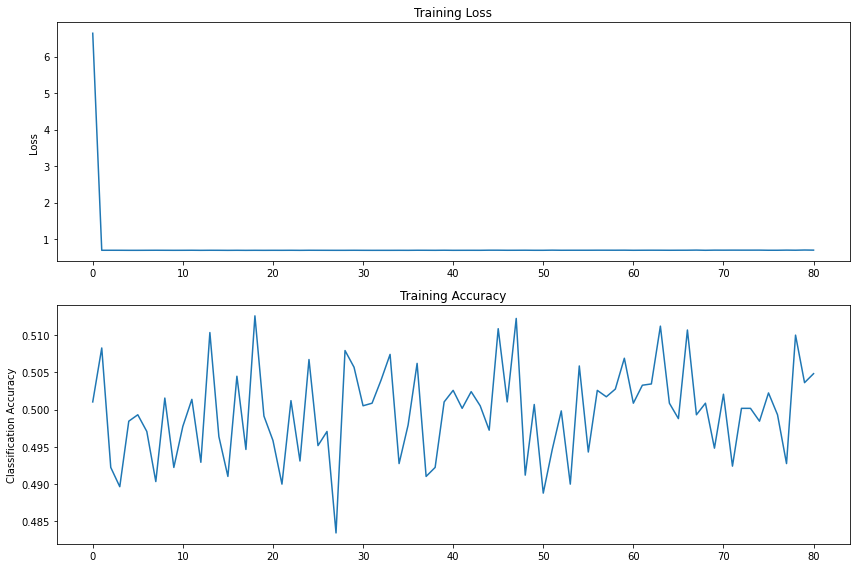

In [170]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# BERT - MLP

In [108]:
tensor_x1 = torch.Tensor(pheme_bert.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_bert.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

In [109]:
# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

task1_train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
task1_test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print(train_size)
print(test_size)


torch.Size([5802, 1, 768])
torch.Size([5802, 1])
5802
485


In [116]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_2(F.elu(self.fc1(x)))
        x = self.drop_2(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [130]:
model = BERT_net()
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task1_model.pt"
best_acc = 10.0
num_epochs = 3

In [131]:
val_corrects_list = []
val_loss_list = []
for epoch in range(num_epochs):  # loop over the dataset multiple times
    # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # print('-' * 10)
    running_corrects = 0.0
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # print(preds)

        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # step function
        scheduler.step() 

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)
    if (epoch%2==0):
        print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch, num_epochs - 1,epoch_acc, epoch_loss))

    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        val_preds_list = []
        val_label_list = []
        for j, val in enumerate(task1_test_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            _, val_preds = torch.max(val_outputs, 1)

            val_preds_list.append(val_preds.data)
            val_label_list.append(val_label.data)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label.data).double()
        if (epoch%2==0):
            val_preds_list = torch.cat(val_preds_list, 0)
            val_label_list = torch.cat(val_label_list, 0)
            print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size,val_loss/test_size,f1_score(val_label_list,val_preds_list,average='macro')))
        val_corrects_list.append(val_corrects/test_size)
        val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(model.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/2	Train) Acc: 0.5034, Loss: 0.6358
		Validation) Acc: 0.2392 Loss:0.6549 F1 score: 0.193012
Saving the best model w/ loss 0.6358
Saving the best model w/ loss 0.6116
Epoch 2/2	Train) Acc: 0.4950, Loss: 0.6070
		Validation) Acc: 0.2392 Loss:0.6627 F1 score: 0.193012
Saving the best model w/ loss 0.6070


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()